In [13]:
import pandas as pd
import os
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
def load_all_data(directory_path):
    '''Завантаження даних з усіх файлів в вказаній папці та обєднання їх в один дата сет'''
    # Створюємо пустий список для зберігання всіх датафреймів
    dataframes = []
    
    # Проходимо по всіх файлах у вказаній папці
    for file in os.listdir(directory_path):
        if file.endswith('.csv'):
            file_path = os.path.join(directory_path, file)
            try:
                df = pd.read_csv(file_path)
                dataframes.append(df)
            except Exception as e:
                print(f"Не вдалося завантажити файл {file}: {e}")
    
    # Об'єднуємо всі датафрейми в один
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df

In [15]:
def visualize_missing_data(dataframe):
    # Створюємо візуалізацію пропущених значень
    plt.figure(figsize=(15, 8))
    msno.matrix(dataframe, sparkline=True, color=(0, 1, 0))
    plt.show()

In [16]:
def data_types_summary(dataframe):
    # Виведення інформації про типи даних у кожному стовпці
    print(dataframe.dtypes)

In [17]:
def missing_values_summary(dataframe):
    # Підрахунок кількості та частки пропусків у кожному стовпці
    missing_summary = dataframe.isnull().sum().to_frame(name='Missing Values')
    missing_summary['Percentage'] = (missing_summary['Missing Values'] / len(dataframe)) * 100
    print(missing_summary)

In [18]:
def visualize_correlation(dataframe):
    # Вибираємо лише числові колонки для кореляції
    numeric_df = dataframe.select_dtypes(include=['number'])
    # Створюємо теплову карту для візуалізації кореляції між числовими стовпцями
    plt.figure(figsize=(15, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Кореляція між числовими стовпцями')
    plt.show()

In [19]:
# Шлях до папки з файлами
directory_path = r'C:\Users\KrisMur\Desktop\PetProjekt1\Apartment_Prices_in_KR-PL-\raw_data'

In [20]:
# Завантажуємо всі дані
all_data_df = load_all_data(directory_path)

<Figure size 1500x800 with 0 Axes>

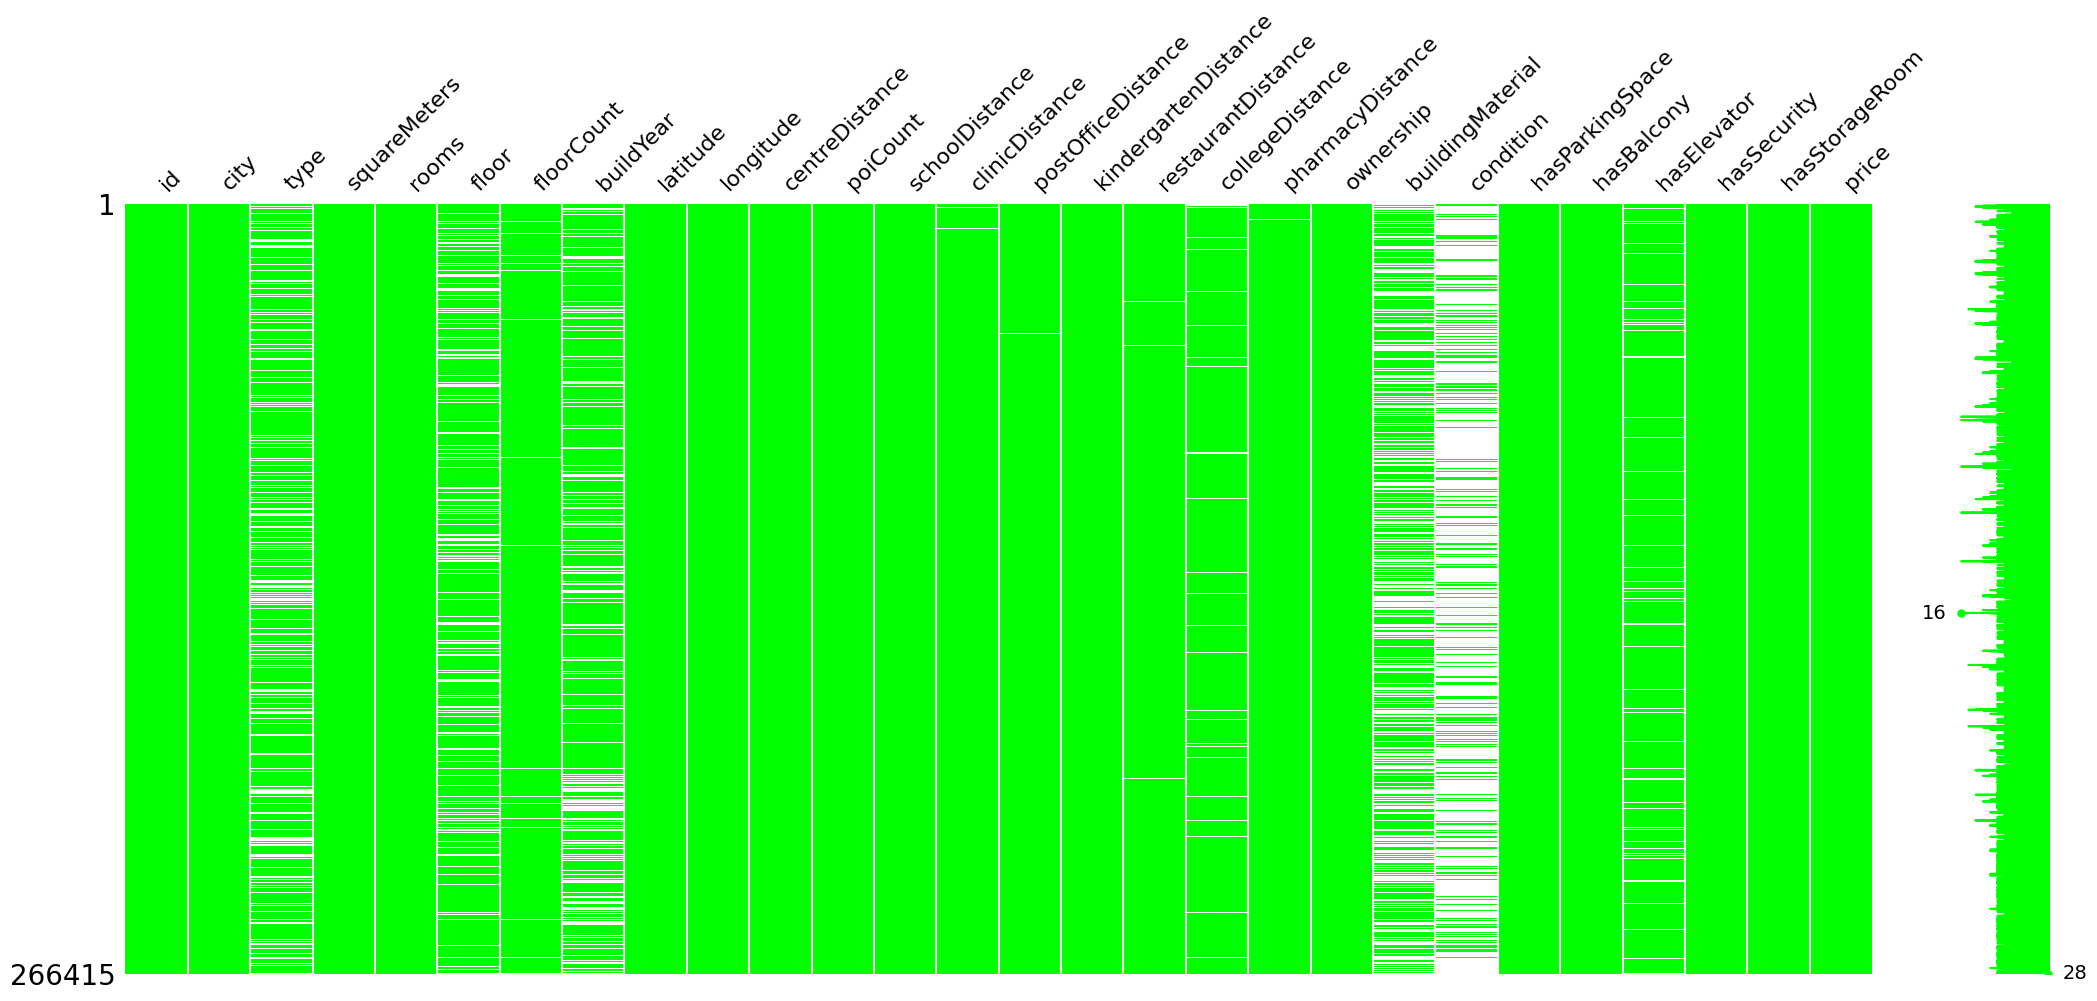

In [21]:
# Створюємо візуалізацію пропущених значень
visualize_missing_data(all_data_df)

За допомогю візуального відображення всього масиву даних, ми можемо проаналізувати якість Дата Сету з точки зоку заповненості даними. Бачимо що наповненість виглядає досить не погано, але є певні які потрібно проаналізувати більш глибше, та прийняти рішення по їх нормалізації. Наприклад, найбільш проблемний показником є condition, в якому присутньо багато пустих рядків, також потребують уваги  більшої уваги buildingMaterial type floor buildTear. ТОму потрібно вивчити дані детальніше. Для початку підрахуємо кількість пустих даних по стовпцям, щоб бачити конкретну ситуацію по кожному стовпцю, та мати більше даних для рішення, як їх обробляти в подальшому

In [22]:
# Викликаємо функцію для підрахунку пропусків
missing_values_summary(all_data_df)

                      Missing Values  Percentage
id                                 0    0.000000
city                               0    0.000000
type                           59023   22.154533
squareMeters                       0    0.000000
rooms                              0    0.000000
floor                          43207   16.217931
floorCount                      3762    1.412083
buildYear                      51898   19.480134
latitude                           0    0.000000
longitude                          0    0.000000
centreDistance                     0    0.000000
poiCount                           0    0.000000
schoolDistance                   183    0.068690
clinicDistance                   778    0.292026
postOfficeDistance               274    0.102847
kindergartenDistance             250    0.093839
restaurantDistance               633    0.237599
collegeDistance                 6310    2.368485
pharmacyDistance                 357    0.134001
ownership           

Після підрахунку пустих значень, ми можемо поділити наявні дані на 3 категорії 
- **Високий відсоток пропусків (> 30%)**:
    - `buildingMaterial` (39.93% пропусків).
    - `condition` (74.31% пропусків).
    
    Дії:
    
    - Стовпець `condition` має дуже велику кількість пропусків. Можливо, варто було б видалити цей стовпець.
    Але я піду іншим шляхом, оскільки інформація про стан квартири має досить високу вагу при аналітиці нерухомості , як і продажу так і оренди. Тому я використаю інший підхід: condition має 2 категорії low та premium. Тобто квартири середнього сегменту або не подані в вибірці , або не мають відповідного позначення. Для збагачення даних в стовпці condition, я проаналізую максимальну та мінімальну ціну для для low та premium сегменту квартир. Та провірю чи ціна на квартиру з відсутнім значенням входить в окіл мін-макс ціни однієї з цих категорій.Якщо так додам вибрану кагорію, якщо ні присвою категорію серднього сегменту.
    
    - Для `buildingMaterial`, спробуємо заповнити пропуски модою (найпоширеніше значення), оскільки матеріал будівлі зазвичай є схожим для типових будинків у певному регіоні.

  2. **Середній відсоток пропусків (10-30%)**:
    - `type` (22.15% пропусків).
    - `buildYear` (19.48% пропусків).
    - `floor` (16.22% пропусків).
        
        Дії:
        - Для `type` заповнимо пропуски модою, оскільки тип об'єкта (наприклад, квартира чи дім) є досить загальною категорією, яка не потребує точних числових оцінок.
        - `buildYear`: можна заповнити середнім або медіанним значенням в залежності від міста.
        - `floor`: можемо заповнити пропуски залежно від `floorCount`. Наприклад, якщо `floorCount` має значення, заповнимо `floor` на основі середнього поверху для будинків із такою ж кількістю поверхів.

  3. **Низький відсоток пропусків (< 10%)**:
    - `floorCount` (1.41% пропусків).
    - Інші стовпці з пропусками: `schoolDistance`, `clinicDistance`, `postOfficeDistance`, `kindergartenDistance`, `restaurantDistance`, `collegeDistance`, `pharmacyDistance`, `hasElevator`.
        
        Дії:
        - **`floorCount`**: заповнимо середнім значенням, оскільки різниця в кількох поверхах зазвичай не є критичною.
        - **Відстані до об'єктів (`schoolDistance`, `clinicDistance` тощо)**: можемо заповнити пропуски середнім значенням у межах міста, оскільки ці змінні можуть суттєво відрізнятися в різних регіонах, але краще поглянемо на кореляцію різних показників, і проаналізуємо чи можемо використати більш точний підхід
        - **`hasElevator`**: заповнимо пропуски залежно від `floorCount`. Зазвичай якщо `floorCount` більше 5 поверхів, можемо припустити, що ліфт наявний і заповнити значення як `yes`.

In [23]:
# Викликаємо функцію для виведення типів даних
data_types_summary(all_data_df)

id                       object
city                     object
type                     object
squareMeters            float64
rooms                   float64
floor                   float64
floorCount              float64
buildYear               float64
latitude                float64
longitude               float64
centreDistance          float64
poiCount                float64
schoolDistance          float64
clinicDistance          float64
postOfficeDistance      float64
kindergartenDistance    float64
restaurantDistance      float64
collegeDistance         float64
pharmacyDistance        float64
ownership                object
buildingMaterial         object
condition                object
hasParkingSpace          object
hasBalcony               object
hasElevator              object
hasSecurity              object
hasStorageRoom           object
price                     int64
dtype: object


Для тогоо щоб більш точно працювати з даними виведоми список типів даних для кожного показника, щоб зрозуміти, які з них числові та в подальшому створити візуаліацію кореляції між ними, щоб більш наочно та глибоко побачити можливі взаємозв'язки та за допомогою них збагатити наш дата сет
4. **Категоріальні змінні (`object` type)**:
    - Для змінних, які є категоріальними (`ownership`, `buildingMaterial`, `condition`, `hasParkingSpace`, `hasBalcony`, `hasSecurity`, `hasStorageRoom`), рекомендується заповнювати пропуски модою.

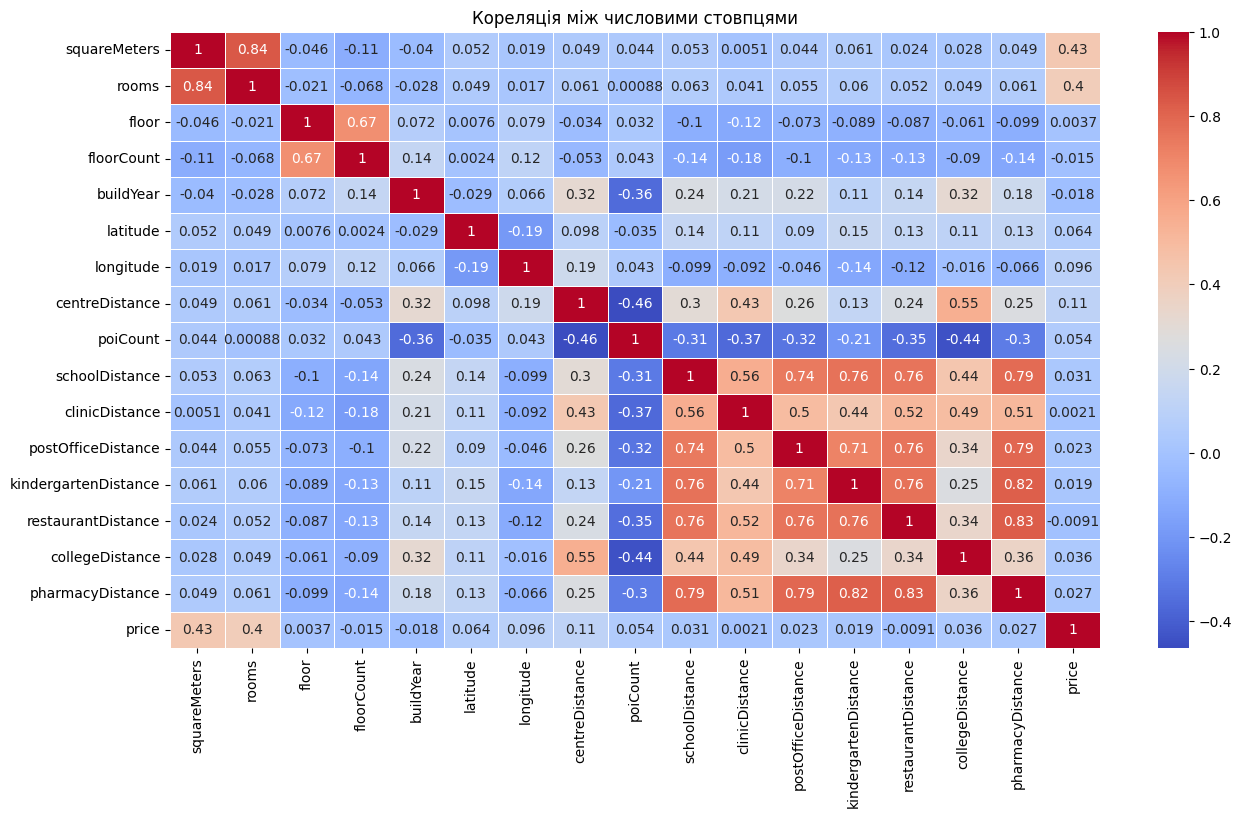

In [24]:
# Викликаємо функцію для візуалізації кореляції
visualize_correlation(all_data_df)


5. **Додатковий аналіз на основі кореляції**:
    - **`squareMeters` та `rooms` мають високу кореляцію (0.84)**. Якщо є пропуски в обох змінних, можна розглянути залежність між площею та кількістю кімнат для заповнення. Наприклад, оцінити середню площу для відповідної кількості кімнат.В нашому дата сеті, це не є необхідним, оскільки ми маємо ці дані в повному обсязі, але ми зможемо використати це в майбутньому, коли зявиться така потреба при доповненні новими даними 
    - **Кореляція між відстанями до об'єктів** (наприклад, `schoolDistance`, `kindergartenDistance`, `collegeDistance`) також висока. Це свідчить про те, що ці змінні можуть бути взаємозамінними або використовуватися одна для заповнення іншої в разі пропусків.